In [1]:
%autosave 0
from __future__ import absolute_import, division, print_function

Autosave disabled


# Walsh-Hadamard Transform (WHT)

In [2]:
%pylab inline
import scipy.linalg
import numpy.matlib
import cv2

Populating the interactive namespace from numpy and matplotlib


## Create the Hadamard matrix

### Do it all by your own

In [3]:
N = 8
assert log2(N) == int(log2(N)), "N has to be a power of 2"

In [4]:
hm = [1]
n = 1
while n < N:
    hm = numpy.matlib.repmat(hm, 2, 2)
    hm[n:2*n,n:2*n] *= -1
    n = len(hm)
hm

array([[ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 1, -1,  1, -1,  1, -1,  1, -1],
       [ 1,  1, -1, -1,  1,  1, -1, -1],
       [ 1, -1, -1,  1,  1, -1, -1,  1],
       [ 1,  1,  1,  1, -1, -1, -1, -1],
       [ 1, -1,  1, -1, -1,  1, -1,  1],
       [ 1,  1, -1, -1, -1, -1,  1,  1],
       [ 1, -1, -1,  1, -1,  1,  1, -1]])

### Visualization of the Walsh functions


Each row of the Walsh-Hadamard matrix corresponds to one sampled Walsh function.

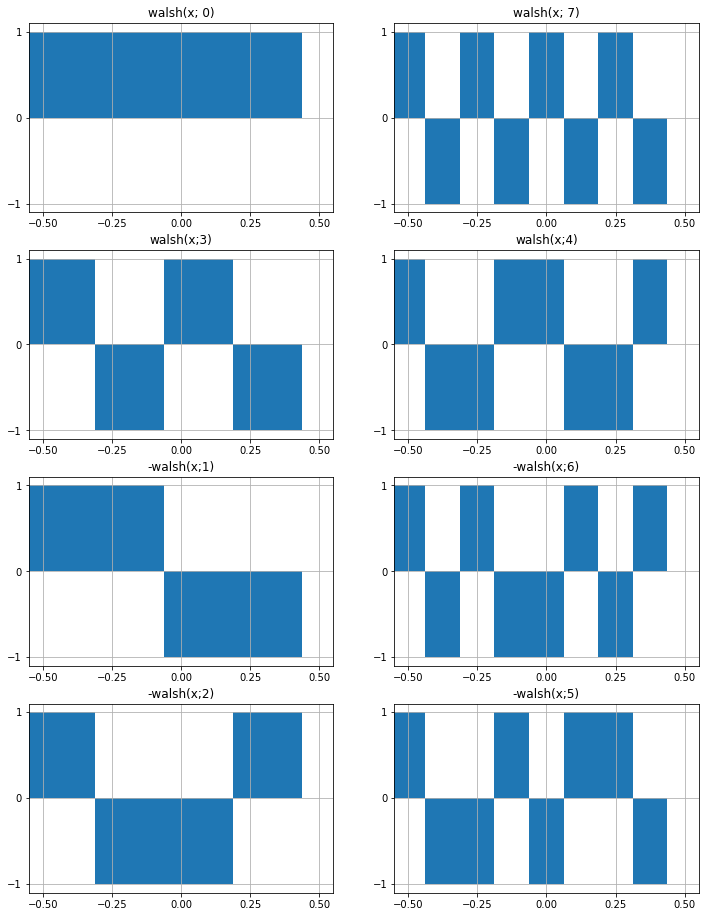

In [5]:
figure(figsize(12, 2*N))
titles = ['walsh(x; 0)', 'walsh(x; 7)', 'walsh(x;3)', 'walsh(x;4)', 
          '-walsh(x;1)', '-walsh(x;6)', '-walsh(x;2)', '-walsh(x;5)']
for i in range(N):
    plt.subplot(N/2,2,i+1)
    plt.bar(linspace(-0.5, 0.5, N+1)[0:N], hm[i], 1/N)
    if N == 8:
        plt.title(titles[i])
    plt.xlim(-.55, 0.55), plt.ylim(-1.1, 1.1), plt.grid()
    plt.xticks(linspace(-.5, .5, N/2+1))
    plt.yticks(linspace(-1, 1, 3));

### Or use the available scipy function

In [6]:
N = 32 # power of 2
assert log2(N) == int(log2(N)), "N has to be a power of 2"
hm = scipy.linalg.hadamard(N)

## Create the Walsh/in sequency matrix: rearrange the rows of the Hadamard matrix

In [7]:
def walsh(N):
    hm = scipy.linalg.hadamard(N)
    
    M = int(np.log2(N) + 1)
    binHadIdx = list()
    for n in range(N):
        # Convert n to a string that contains the binary representation.
        # Pad the numeric string on the left with zero digits until the given width M is reached. 
        # Reverse the string
        bin_string = "{0:0b}".format(n).zfill(M)[::-1]
        
        # Convert the string to an array representation
        t = []
        for letter in bin_string:
            t.append(ord(letter) - ord('0'))
        binHadIdx.append(t)
    binHadIdx = np.asarray(binHadIdx)

    # xor adjacent columns
    binSeqIdx = np.zeros((N, M))
    for k in range(M-1, 0, -1): # [M-1, M-2, ..., 1]
        binSeqIdx[:,k] = np.bitwise_xor(binHadIdx[:,k], binHadIdx[:,k-1])
    binSeqIdx = np.mat(binSeqIdx, dtype=np.int)

    # convert binary array representation to number
    h = np.mat(np.power(2, range(M-1, -1, -1))) # [[2^(M-1), 2^(M-2), ..., 2, 1]]
    seqIdx = binSeqIdx * h.transpose()
    seqIdx = np.asarray(seqIdx).flatten()
    
    # print(binHadIdx)
    # print(binSeqIdx)
    # print(seqIdx)

    return hm[seqIdx]

In [8]:
wm = walsh(N)

## Visualization

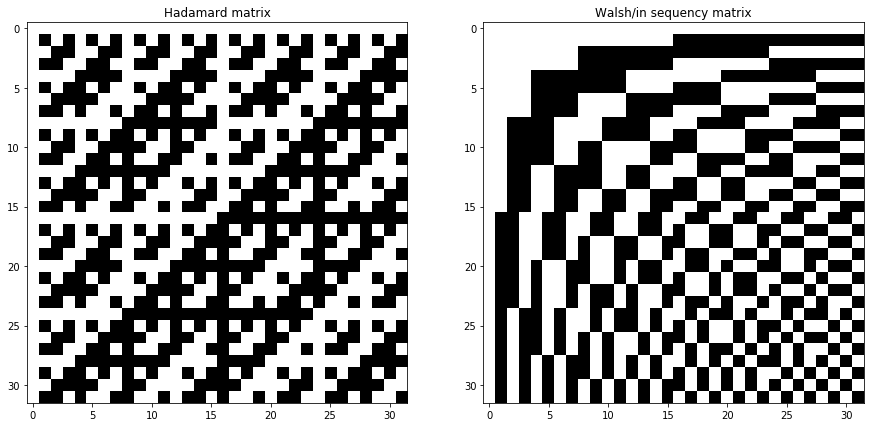

In [9]:
figure(figsize(15,7))
plt.subplot(1,2,1), plt.imshow(hm, interpolation='nearest', cmap='gray');
plt.title("Hadamard matrix")
plt.subplot(1,2,2), plt.imshow(wm, interpolation='nearest', cmap='gray');
plt.title("Walsh/in sequency matrix");

## WHT of an image

### Load the image

In [10]:
img = cv2.imread('lena.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
N, M = img.shape
assert N == M, "Input image not quadratic: {0} x {1}".format(N, M)
assert log2(N) == int(log2(N)), "Width of the image has to be a power of 2"

In [11]:
img_mat = np.mat(img, dtype=np.int32);
# img_mat = img_mat / 255.0
img_mat.min(), img_mat.max()

(25, 245)

### Create the Hadamard and the Walsh/in sequency matrix

In [12]:
hm = scipy.linalg.hadamard(N)
m = wm = walsh(N)
m = np.mat(m, dtype=np.int8)

### 2-D WHT

In [13]:
wht1 = m * img_mat * m.T / N
wht1.min(), wht1.max()

(-6788.26953125, 63512.87109375)

### Plot the 2-D WHT (with adjusted range of gray values)

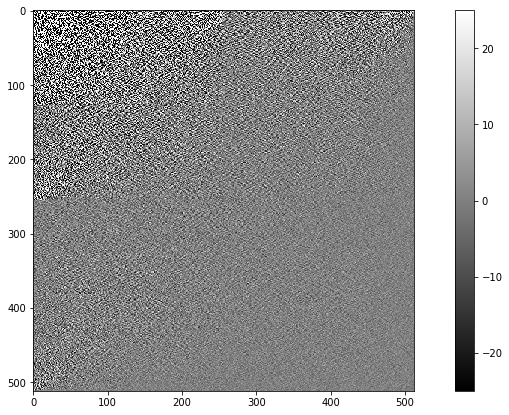

In [14]:
# Show values between [-c, +c]; larger values are set to +c, smaller ones to -c
c = 25
tmp = np.where(wht1 > c, c, wht1)
tmp = np.where(tmp < -c, -c, tmp)
plt.imshow(tmp, 'gray')
# plt.imshow(wht1[c:, c:], 'gray')
plt.colorbar();

### Inverse WHT

In [15]:
recon1 =  m.dot(wht1).dot(m.T) / N
recon1.min(), recon1.max()

(25.0, 245.0)

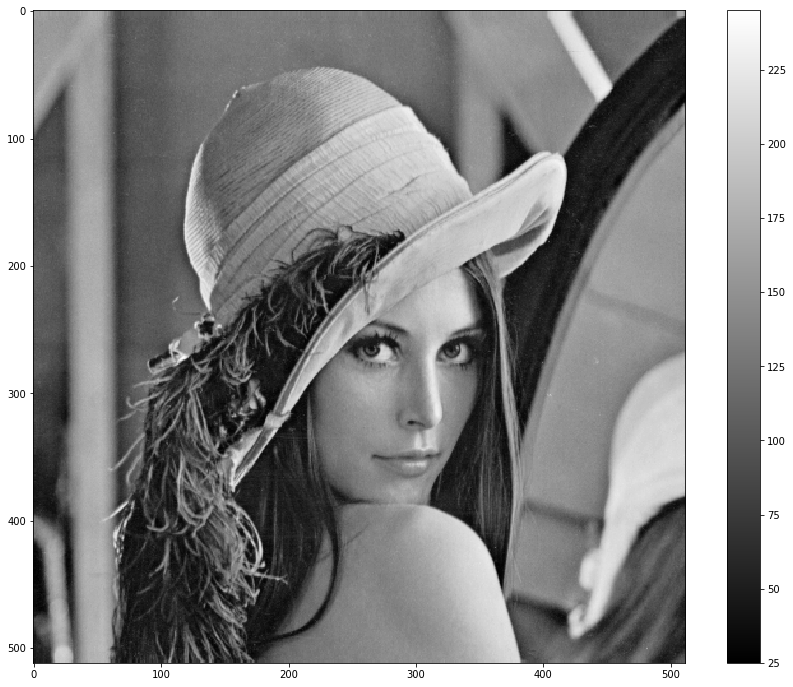

In [16]:
figure(figsize(15,12))
plt.imshow(recon1, 'gray'), plt.colorbar();

### Setting 75% of the high frequency components to zero

In [17]:
wht2 = wht1.copy()
wht2[:, int(N/2):] = 0
wht2[int(N/2):, :] = 0

In [18]:
recon2 = m.dot(wht2).dot(m.T) / N

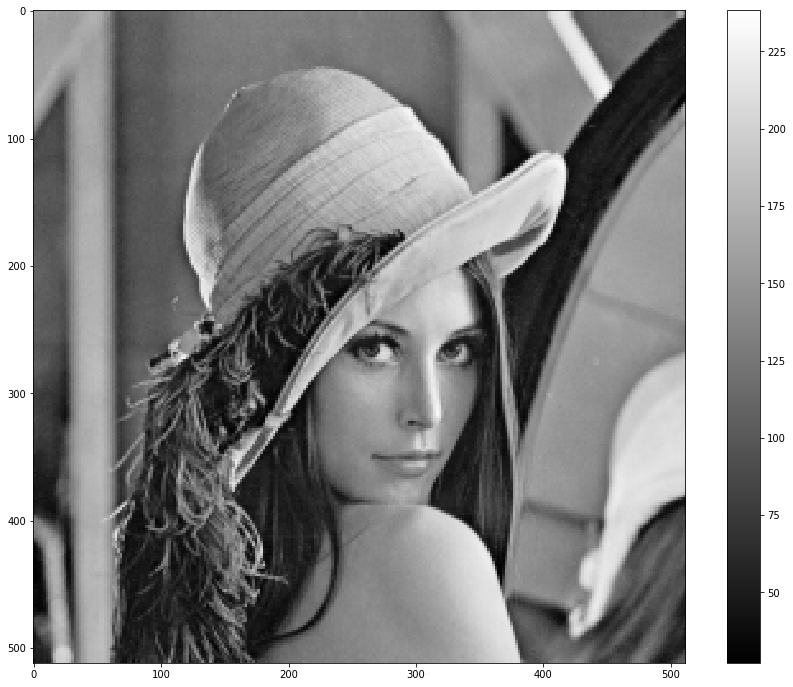

In [19]:
figure(figsize(15,12))
plt.imshow(recon2, 'gray'), plt.colorbar();

### Setting 93.75% of the high frequency components to zero

In [20]:
wht3 = wht1.copy()
wht3[:, int(N/4):] = 0
wht3[int(N/4):, :] = 0

In [21]:
recon3 = m.dot(wht3).dot(m.T) / N

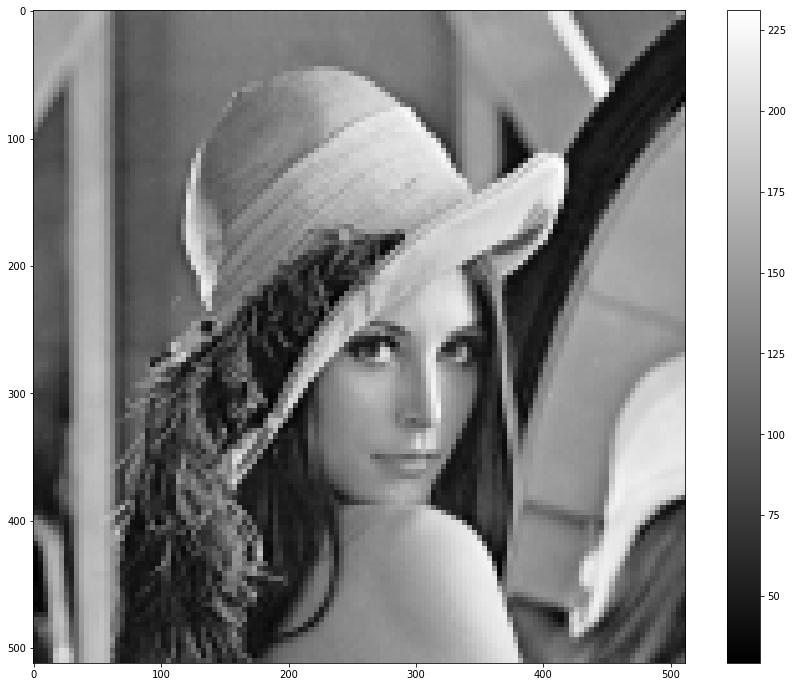

In [22]:
figure(figsize(15,12))
plt.imshow(recon3, 'gray'), plt.colorbar();